# Advanced programming lab: Mandelbrot zoom
 
*version 1, since this lab is new for 2020, details/bugs in this lab might be fixed within the first week of publication, you will be notified by email if this happens*
 
The mandelbrot zoom was a classic rite of initiation in some hacker circles in the 90s. For this lab, you are given code for generating such a mandelbrot zoom, however, the code is written in pure python and is really slow. Your task is as follows:
 
1. Copy the given mandelbrot code to the the prepared cython code cell below.
2. Step by step, optimise the code using the tricks discussed in class.
3. The rendering of the frames is an *embarrassingly parallel* task. See to that your frames are rendered on several CPU cores.
4. Generate a 500 frame video at a 1000x1000 pixel resolution.
 
Your implementation should be **at least** 50 times faster than the given code on an 8 core system.
 
## Submission
 
When you are done, hand in the notebook through studentportalen. Requirements are:
1. Clean the notebook from unused code and unnecessary text.
2. Save the notebook with plotted images, but not the video (it’s too large).
3. Comment on what was hard and easy in the assignment (in a handful of sentences).

First, we need some libraries. The line profiler needs some underlying software to work.

In [1]:
import numpy as np
import cv2 # open computer vision library, for video and image processing
import matplotlib.pyplot as plt

# Code for enabling line specific profiling
!pip install line-profiler
%load_ext line_profiler

The numbers in the Mandelbrot set are all complex numbers $c$, such that the series $z_0=(0, 0)$ and $z_{t+1} = z_t^2 + c$ is bounded (i.e. it does not go to infinity). $c$ is a complex constant depending on the position in the image being processed. We set the pixel colour in relation to the number of iterations in the series before it diverges, defined as $|z_t| > 2$.

In [5]:
def mandelbrot(centre, view_side, n_max_iter = 500, view_side_pixels = 500):
  # The output is a square image, view_side is the size of the side of this
  # image in the complex plane. The view_side_pixels is the number of pixels
  # this correspond to.
  step = view_side/view_side_pixels
  # Store the pixels as a list of lists
  image = list()
  for i in range(view_side_pixels):
    image.append([])
    for j in range(view_side_pixels):
      # Find c for this pixel
      c = centre + view_side*complex(-.5, .5) + complex(j*step, -i*step)
      # Initial z
      z = complex(0, 0)
      # Iterate to generate the series
      n = 0
      # Loop until a maximum number of allowed iterations or until the 
      # series diverges.
      while n < n_max_iter and abs(z) < 2: 
        # The update
        z = z*z + c
        # Increase the iteration counter
        n += 1
      # If the series did diverge, store the number of iterations it took (our
      # colouring will be proportional to this). If not, store a zero.
      if n == n_max_iter:
        image[i].append(0)
      else:
        image[i].append(n)
  # Transform the list of lists into a numpy matrix
  return np.asarray(image)

This code is for viewing the generated image. A colourmap is applied to the raw counts of iterations before diverging. There are more beautiful colourmaps, but none in opencv. You can try out other colourmaps as described [here](https://docs.opencv.org/3.4.9/d3/d50/group__imgproc__colormap.html).

Note that opencv use BGR instead of RGB colour ordering.

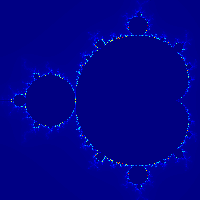

In [22]:
# Make the image
image = mandelbrot(complex(-.5,-0), 2, view_side_pixels = 200)
#image = mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)

# Apply colourmap
img = np.asarray(255*image/np.max(image), dtype=np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

# Optional resize (makes it look better at higher resolutions)
# img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

# Write the image and view it
cv2.imwrite('fractal.png', img)
from IPython.display import Image
Image('fractal.png')

To get an idea of where to start optimising, run the following cell profiling the given mandelbrot function. Try to find a critical inner loop and calculate the relative time spent there.

In [5]:
%lprun -f mandelbrot mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)

## Making a video zooming in on the fractal image

In [6]:
from tqdm import tqdm

frames = list()
for zoom in tqdm(np.exp(np.linspace(np.log(1), np.log(.00001), 10))):
  # Create the image for the given parameters
  image = mandelbrot(complex(-0.743643887037158704752191506114774, 0.131825904205311970493132056385139), zoom, n_max_iter=255, view_side_pixels = 100)
  
  # Apply colourmap
  img = np.asarray(255*image/np.max(image), dtype=np.uint8)
  img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

  # Optional resize (makes it look better at higher resolutions)
  img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

  # Store the frame
  frames.append(img)

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Just to see what came out, the following cell shows the first, middle and last frames.

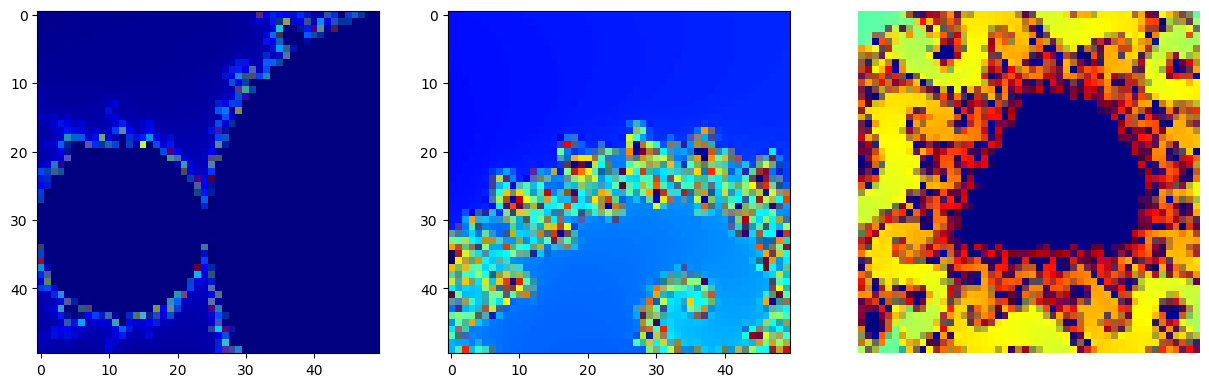

In [7]:
plt.figure(figsize=(15, 5), dpi=100)
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(frames[len(frames)//2], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(frames[-1], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

This writes the video to disk. Note that if you do this through colab, your video will be written to the viritual machine's disk. You can find some code for downloading the file below.

In [8]:
# Choose video format
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
fourcc = cv2.VideoWriter_fourcc(*'MP4V')

# Prepare the writer class
video = cv2.VideoWriter('fractal.mp4',fourcc, 20, (img.shape[0], img.shape[1]))

# Input the frames
for frame in frames:
  video.write(frame)

# Write to disk
video.release()

# Show the files in your working directory
!ls -l

total 280
-rw-r--r--@ 1 yonwu  staff  110511 Feb 24 12:45 AdvProg_Assignment_3_Mandelbrot_zoom.ipynb
-rw-r--r--  1 yonwu  staff   19665 Feb 24 12:45 fractal.mp4
-rw-r--r--  1 yonwu  staff   10730 Feb 24 12:33 fractal.png


## Cython implementation

These cells are meant to be used as a sandbox for cython development. Add code for writing the viedo when you are finished optimising the rendering.

This load the cython extension. It enables the use of the cython magic command.

In [3]:
%load_ext cython


As a reminder of how to do cython, here comes a cell where you can develop your cython code.

In [23]:
def mandelbrot(centre, view_side, n_max_iter = 500, view_side_pixels = 500):
  # The output is a square image, view_side is the size of the side of this
  # image in the complex plane. The view_side_pixels is the number of pixels
  # this correspond to.
  step = view_side/view_side_pixels
  # Store the pixels as a list of lists
  image = list()
  for i in range(view_side_pixels):
    image.append([])
    for j in range(view_side_pixels):
      # Find c for this pixel
      c = centre + view_side*complex(-.5, .5) + complex(j*step, -i*step)
      # Initial z
      z = complex(0, 0)
      # Iterate to generate the series
      n = 0
      # Loop until a maximum number of allowed iterations or until the 
      # series diverges.
      while n < n_max_iter and abs(z) < 2: 
        # The update
        z = z*z + c
        # Increase the iteration counter
        n += 1
      # If the series did diverge, store the number of iterations it took (our
      # colouring will be proportional to this). If not, store a zero.
      if n == n_max_iter:
        image[i].append(0)
      else:
        image[i].append(n)
  # Transform the list of lists into a numpy matrix
  return np.asarray(image)

%lprun -f mandelbrot mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)

In [45]:
%%cython -a
import numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def mandelbrot_cy(centre, view_side, int n_max_iter = 255, int view_side_pixels = 500):
    
    cdef double step = view_side/view_side_pixels
    
    image = np.zeros((view_side_pixels, view_side_pixels), dtype=np.intc)
    cdef double[:,:] image_memview = image
    cdef int i, j, n
    cdef double c
    
    for i in range(view_side_pixels):
        for j in range(view_side_pixels):
            c = centre + view_side*complex(-.5, .5) + complex(j*step, -i*step)
            z = complex(0, 0)
            n = 0
            while n < n_max_iter and abs(z)<2:
                z = z*z + c
                n += 1
            if n == n_max_iter:
                image_memview[i, j] = 0
            else:
                image_memview[i, j] = n
    
    return image_memview



In [ ]:
%%cython -a
import numpy as np
cimport cython
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def mandelbrot_cy(complex centre, double view_side, int n_max_iter = 255, int view_side_pixels = 500):
  # The output is a square image, view_side is the size of the side of this
  # image in the complex plane. The view_side_pixels is the number of pixels
  # this correspond to.
  cdef double step = view_side / view_side_pixels
  cdef int i, j, n
  # Store the pixels as a list of lists
  cdef image = np.zeros((view_side_pixels, view_side_pixels), dtype=np.intc)
  cdef double creal = centre.real
  cdef double cimag = centre.imag
  cdef double c1, c2, z1, z2, tmp
  #image = list()
  for i in range(view_side_pixels):
    #image.append([])
    for j in range(view_side_pixels):
      # Find c for this pixel
      #c = centre + view_side*complex(-.5, .5) + complex(j*step, -i*step)
      c1 = creal + view_side * (-0.5) + j * step
      c2 = cimag + view_side * 0.5 - i * step
      # Initial z
      #z = complex(0, 0)
      z1 = 0
      z2 = 0
      # Iterate to generate the series
      n = 0
      # Loop until a maximum number of allowed iterations or until the 
      # series diverges.
      while n < n_max_iter and z1 < 2 and z2 < 2 and z1 > -2 and z2 > -2: 
        # The update
        #z = z*z + c
        tmp = z1
        z1 = z1 * z1 - z2 * z2 + c1
        z2 = 2 * tmp * z2 + c2
        # Increase the iteration counter
        n += 1
      # If the series did diverge, store the number of iterations it took (our
      # colouring will be proportional to this). If not, store a zero.
      if n < n_max_iter:
        #image[i].append(n)
        image[i,j] = n
  # Transform the list of lists into a numpy matrix
  #return np.asarray(image)
  return image

In [47]:
# Make the image
image = mandelbrot_cy(complex(-.5,-0), 2, view_side_pixels = 200)
#image = mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)

# Apply colourmap
img = np.asarray(255*image/np.max(image), dtype=np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

# Optional resize (makes it look better at higher resolutions)
# img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

# Write the image and view it
cv2.imwrite('fractal.png', img)
from IPython.display import Image
Image('fractal.png')

ValueError: Buffer dtype mismatch, expected 'double' but got 'int'

When you have something that works well, the following code can be used for loading the function as a module function. This avoids the serialisation/pickeling of the function when using multiprocessing.

In [11]:
%%writefile _mandelbrot.pyx
#cython: language_level=3

import numpy as np
cimport cython

def _mandelbrot_cy(centre, view_side, int n_max_iter = 255, int view_side_pixels = 500):
  image = np.zeros((view_side_pixels, view_side_pixels), dtype=np.intc)
  return image

Writing _mandelbrot.pyx


Pyximport lets you load cython code as a library and compiles it at loading time. There is also a handy caching of compiled modules, so that you don't recompile on every load of the module. However, this can also lead to problems when developing.

In [12]:
import pyximport
pyximport.install()

from _mandelbrot import _mandelbrot_cy

## Compare execution times



In [13]:
%timeit mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)
%timeit mandelbrot_cy(complex(-.74303, .126433), .01611, view_side_pixels = 200)

1.38 s ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.11 µs ± 35.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Code for moving the data from colab to google drive.

In [0]:
# from google.colab import drive
# drive.mount('/gdrive')
# !cp fractal.mp4 /gdrive/'My Drive'/